# Image Classification: Implementation of ResNet from scratch

In this seconf notebook, we implement the classification of the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), containing of 32x32 colour images in 10 classes (cats, birds, airplanes, etc.).

Contrary to our first work, where we used transfer learning, here, we have to build a Residual Neuronal Newtork ([ResNet](https://arxiv.org/abs/1512.03385)) and train it by ourselves, to differentialte the different classes of the dataset.

Indeed, the **pre-trained** models of *torchvision* are trained on large size images, and therefore are not adapted to smaller images like the ones of the CIFAR10 dataset.


In [23]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils


We use here the **torchvision** library ([click here for more details](https://pytorch.org/vision/stable/index.html)). This library is part of the Pytorch project, and consists of popular datasets, model architectures, and common image transformations for computer vision.

## Data Augmentation 

We randomly rotate, flip and crop the input images, in order to introduce some randomness. This will improve the training of our network, by making our predictions more robust to image transformations. 

In [65]:
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# We define the transforms for the training data and testing data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])


# Download and load the training data
trainset = datasets.CIFAR10(root='./data', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset = datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)




# prepare data loaders (combine dataset and sampler)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)



Files already downloaded and verified
Files already downloaded and verified


In [24]:
from torch.utils.data.sampler import SubsetRandomSampler



# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


We look at a batch of images to see if they have been loaded well.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


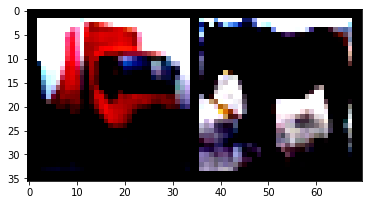

In [25]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # from torch to plt image format
    plt.show()

# We get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# We show some images
imshow(utils.make_grid(images[0:2]))

In [43]:
images.shape

torch.Size([16, 3, 32, 32])

## CNN Implementation (Transfer Learning)

We now implement our neuronal network, that will be divided into **2 parts**.

The first part of our neuronal network is a **pre-trained model**: the [ResNet](https://arxiv.org/abs/1512.03385) model.
This part of our network permits to detect the features of the images thanks to an efficient model that has been already trained on a lot of data.

The second part of our neuronal network is the **classifier**, that takes the output of the ResNet as input, and classifies our images thanks to the observed features.

In [62]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
        self.fc1 = nn.Linear(in_features = 16 * 5 * 5, out_features = 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

We use the *Cross Entropy* loss function and the *Adam* optimizer.

In [63]:
# We define the loss criterion
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=0.003)

# We use GPU if it's available, and the CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

## Training and Validation

In [64]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss
best_accuracy = 0.0

epoch_all = []  # to keep the accuracies calculated at each epoch, to plot them later
epoch_acc_all = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    running_corrects = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in trainloader:
        # move tensors to GPU if CUDA is available
        images, labels = images.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing images to the model
        output = model.forward(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for images, labels in testloader:
        # move tensors to GPU if CUDA is available
        images, labels = images.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing images to the model
        output = model.forward(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
        # take as prediction the label with highest output (highest probability)
        _, pred = torch.max(output, 1)
        # total number of correct predictions
        running_corrects += torch.sum(pred == labels)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    
    # claculate test accuracy
    epoch_acc = running_corrects.double() / len(validloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss,epoch_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        
    # We keep the accuracies at each epoch, to plot them later
    epoch_all.append(epoch)    
    epoch_acc_all.append(epoch_acc)
        


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x576 and 144x120)

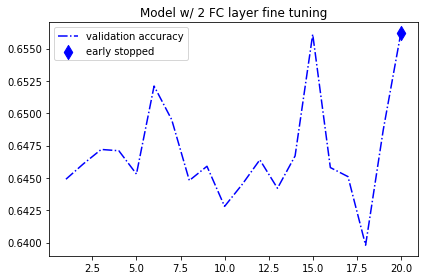

In [42]:
max_epoch = max(epoch_all)      
max_epoch_acc = max(epoch_acc_all)    

plt.plot(epoch_all, epoch_acc_all, label="validation accuracy", color="blue", linestyle='-.')
#plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
plt.scatter([max_epoch], [max_epoch_acc],color="blue", marker="d", label="early stopped", s=100 )
plt.title("Model w/ 2 FC layer fine tuning")
plt.legend()
plt.tight_layout()
plt.savefig('fctuning2[224].png',dpi=600)
plt.show()

# Results

Average validation accuracy (on 3 last epochs) obtained :

* **ResNet**:
- With 0.5-normalization : 0.44
- With Adapted-normalization : 0.44
- With Adapted-normalization + Rotate : 0.35
- With Adapted-normalization + Flip : 0.44
- Same but Batch size 64 instead of 20 : 0.46
- With Adapted-normalization + Flip + Rotate :
- With Adapted-normalization + Flip + Rotate + Crop :

* **Inception v3** :
- With Batch size 64 + Adapted-normalization + Flip :



## DATA LOADING: VEDERE PERCHE NON FUNZIONAVA !!!


In [ ]:
import torchvision


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 10
learning_rate = 0.003

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64, 
                                          shuffle=False)

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Files already downloaded and verified
Epoch [1/10], Step [100/782] Loss: 1.8523
Epoch [1/10], Step [200/782] Loss: 1.4390
Epoch [1/10], Step [300/782] Loss: 1.5540
Epoch [1/10], Step [400/782] Loss: 1.4864
Epoch [1/10], Step [500/782] Loss: 1.3628
Epoch [1/10], Step [600/782] Loss: 1.3817
Epoch [1/10], Step [700/782] Loss: 1.0555
Epoch [2/10], Step [100/782] Loss: 0.8915
Epoch [2/10], Step [200/782] Loss: 0.9003
Epoch [2/10], Step [300/782] Loss: 1.1405
Epoch [2/10], Step [400/782] Loss: 1.0899
Epoch [2/10], Step [500/782] Loss: 1.1089
Epoch [2/10], Step [600/782] Loss: 1.1366
Epoch [2/10], Step [700/782] Loss: 0.9605
Epoch [3/10], Step [100/782] Loss: 0.9682
Epoch [3/10], Step [200/782] Loss: 1.0527
Epoch [3/10], Step [300/782] Loss: 1.1117
Epoch [3/10], Step [400/782] Loss: 0.7594
Epoch [3/10], Step [500/782] Loss: 1.0978
Epoch [3/10], Step [600/782] Loss: 0.6310
Epoch [3/10], Step [700/782] Loss: 0.7751
Epoch [4/10], Step [100/782] Loss: 0.5439
Epoch [4/10], Step [200/782] Loss: 0.9

KeyboardInterrupt: 